In [1]:
import pandas as pd
from transformers import AutoTokenizer, AutoModel
import torch
import numpy as np
from sentence_transformers import SentenceTransformer

Read in the LHCb manuscripts, labelled as per ACLM

In [2]:
lhcb_corpus_df = pd.read_pickle("/work/submit/blaised/beauty-in-stats/src/dev/agents/lhcb_papers_20250204_133251.pkl")

Establish a new column mapping papers to their respective abstract latex source code

In [3]:
import numpy as np
import os

# Define the path to the abstracts directory
abstracts_dir = "/work/submit/blaised/beauty-in-stats/data/abstracts"

# Function to load abstract from a .tex file
def load_abstract(arxiv_id):
    tex_file_path = os.path.join(abstracts_dir, f"{arxiv_id}.tex")
    if os.path.exists(tex_file_path):
        with open(tex_file_path, 'r') as file:
            return file.read()
    return np.nan

# Apply the function to create a new column 'abstract'
lhcb_corpus_df['abstract'] = lhcb_corpus_df['arxiv_id'].apply(load_abstract)


Filter away papers for which we have not yet fetched the abstract

In [4]:
lhcb_corpus_df = lhcb_corpus_df[lhcb_corpus_df['abstract'].notna()]

Load the elected embedding model and tokenizer

In [26]:
class EmbeddingModelTokenizerFactory:
    def __init__(self, model_name: str, cache_dir: str = "/ceph/submit/data/user/b/blaised/llm/huggingface_cache/"):
        self.model_name = model_name
        self.cache_dir = cache_dir
    def source_model(self):
        match self.model_name:
            case "physbert_cased":
                model_id = "thellert/physbert_cased"
                return self.get_hf_model_tokenizer(model_id)
            case "modernbert_large":
                model_id = "lightonai/modernbert-embed-large"
                return SentenceTransformer(model_id, cache_folder = self.cache_dir)
            case _:
                raise ValueError(f"Model {self.model_name} not supported")

    def get_hf_model_tokenizer(self, model: str):
        return AutoTokenizer.from_pretrained(model, cache_dir=self.cache_dir), AutoModel.from_pretrained(model, cache_dir=self.cache_dir)

In [27]:
# physbert_tokenizer, physbert_model = EmbeddingModelTokenizerFactory("physbert_cased").source_model()
modernbert_embedder = EmbeddingModelTokenizerFactory("modernbert_large").source_model()

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/227 [00:00<?, ?B/s]

You try to use a model that was created with version 3.4.0.dev0, however, your version is 3.3.1. This might cause unexpected behavior or errors. In that case, try to update to the latest version.





README.md:   0%|          | 0.00/445k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/54.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.27k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.58G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/20.8k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.58M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/297 [00:00<?, ?B/s]

In [157]:
# Generate embeddings for each abstract
def generate_embeddings(abstract):
    inputs = tokenizer(abstract, return_tensors="pt")
    try:
        with torch.no_grad():  # Disable gradient calculation for inference
            outputs = model(**inputs)
            return outputs.last_hidden_state[:, 1:-1, :].mean(dim=1).squeeze().numpy() # Drop CLS and SEP tokens, then take the mean for the sentence embedding
    except Exception as e:
         return np.nan # NOTE: exceeds the context window of BERT but we want to keep the monolithic arxiv text

In [158]:
# Apply the function to create a new column 'embeddings'
lhcb_corpus_df['embeddings'] = lhcb_corpus_df['abstract'].apply(generate_embeddings)

In [159]:
# filter away with len(token(abstract)) > 512
lhcb_corpus_df = lhcb_corpus_df[lhcb_corpus_df['embeddings'].notna()]

In [160]:
lhcb_corpus_df.head(25)

,lhcb_paper_id,arxiv_id,journal,working_groups,data_taking_years,run_period,abstract,embeddings
5,LHCb-PAPER-2024-020,2412.14074,JHEP,[b_decays_to_open_charm],"[2015, 2016, 2017, 2018]",Run2,A measurement of the CP-violating parameters i...,"[1.3672975, 0.19801067, 0.85807, -0.08029646, ..."
6,LHCb-PAPER-2024-048,2412.13958,PRD,[charmless_b_hadron_decays],"[2011, 2012, 2015, 2016, 2017, 2018]",Run1+Run2,A search for $CP$ violation in $\Lambda_b^0\ri...,"[1.2249857, 0.10194132, 0.4814402, 0.22020954,..."
7,LHCb-PAPER-2024-046,2412.11645,PRL,[rare_decays],"[2011, 2012, 2015, 2016, 2017, 2018]",Run1+Run2,The first test of lepton flavour universality ...,"[1.3318235, -0.14090224, 0.9173821, 0.15363325..."
8,LHCb-PAPER-2024-047,2412.09414,PRL,[charm_physics],"[2015, 2016, 2017, 2018]",Run2,A search for $D^0$ meson decays to the $\pi^+\...,"[0.78898996, -0.28601274, 0.8399321, -0.004818..."
9,LHCb-PAPER-2024-040,2411.19781,PRL,[b_decays_to_open_charm],"[2011, 2012, 2015, 2016, 2017, 2018]",Run1+Run2,An amplitude analysis of $B^-\rightarrow D^- D...,"[0.6136024, -0.5271073, 0.77286905, 0.9180341,..."
10,LHCb-PAPER-2024-043,2411.15441,PRL,[charmless_b_hadron_decays],"[2011, 2012, 2015, 2016, 2017, 2018]",Run1+Run2,A study of Λ 0 b and Ξ0 b decays to Λh+h ′− (h...,"[1.4029845, -0.29273286, 1.099138, -0.212322, ..."
12,LHCb-PAPER-2024-030,2411.10219,JHEP,[rare_decays],"[2011, 2012, 2015, 2016, 2017, 2018]",Run1+Run2,An angular analysis of the $B_s^0 \rightarrow ...,"[0.892579, 0.101102404, 0.97477543, -0.3126298..."
13,LHCb-PAPER-2024-036,2411.09343,JHEP,[ions_and_fixed_target],[2017],Run2,The first measurement of $\phi(1020)$ meson pr...,"[1.0615785, 0.17124286, 1.0873203, -0.24889342..."
14,LHCb-PAPER-2024-041,2411.05669,JHEP,[ions_and_fixed_target],[2018],Run2,The dissociation of quarkonium states with dif...,"[1.0443636, -0.54994565, 1.3400444, 0.319507, ..."
16,LHCb-PAPER-2024-023,2410.21115,JHEP,[b_decays_to_open_charm],"[2011, 2012, 2015, 2016, 2017, 2018]",Run1+Run2,Measurements of $CP$ observables and the CKM a...,"[1.3390342, -0.34378865, 0.61947703, 0.3360153..."


OK, now we can study the performance of the embeddings:
- Perform K-means clustering on the embeddings
- Project out the PCA of the embeddings and compare again the the 'working_group' label

Before, however, we need can mask away the working groups in which we are not interested

In [161]:
# Define working groups to exclude
exclude_groups = {'', 'flavour_tagging', 'run_1_2_performance_formely_tracking_alignment_vertexing_and_pid_and_calo_objects', 'luminosity'}  # operations and unassigned

# Create mask that keeps only rows where none of the working groups are in exclude_groups
mask = lhcb_corpus_df['working_groups'].apply(lambda x: not any(group in exclude_groups for group in x))

# Apply the mask
lhcb_corpus_df = lhcb_corpus_df[mask]

In [162]:
wg_labels = lhcb_corpus_df['working_groups'].explode().unique()

In [163]:
print(wg_labels)

['b_decays_to_open_charm' 'charmless_b_hadron_decays' 'rare_decays'
 'charm_physics' 'ions_and_fixed_target' 'qcd_electroweak_and_exotica'
 'b_hadrons_and_quarkonia' 'soft_qcd_and_central_exclusive_production'
 'semileptonic_b_decays' 'b_decays_to_charmonia'
 'b_hadrons_bc_and_exotic_spectroscopy']


In [181]:
flattened_embeddings = np.stack(
    lhcb_corpus_df['embeddings'].apply(lambda x: x.flatten())
)

In [184]:
# perform K-means clustering on the embeddings
from sklearn.cluster import KMeans

# kmeans clustering
kmeans = KMeans(n_clusters=len(wg_labels), random_state=42)
kmeans.fit(flattened_embeddings)

KMeans(n_clusters=11, random_state=42)

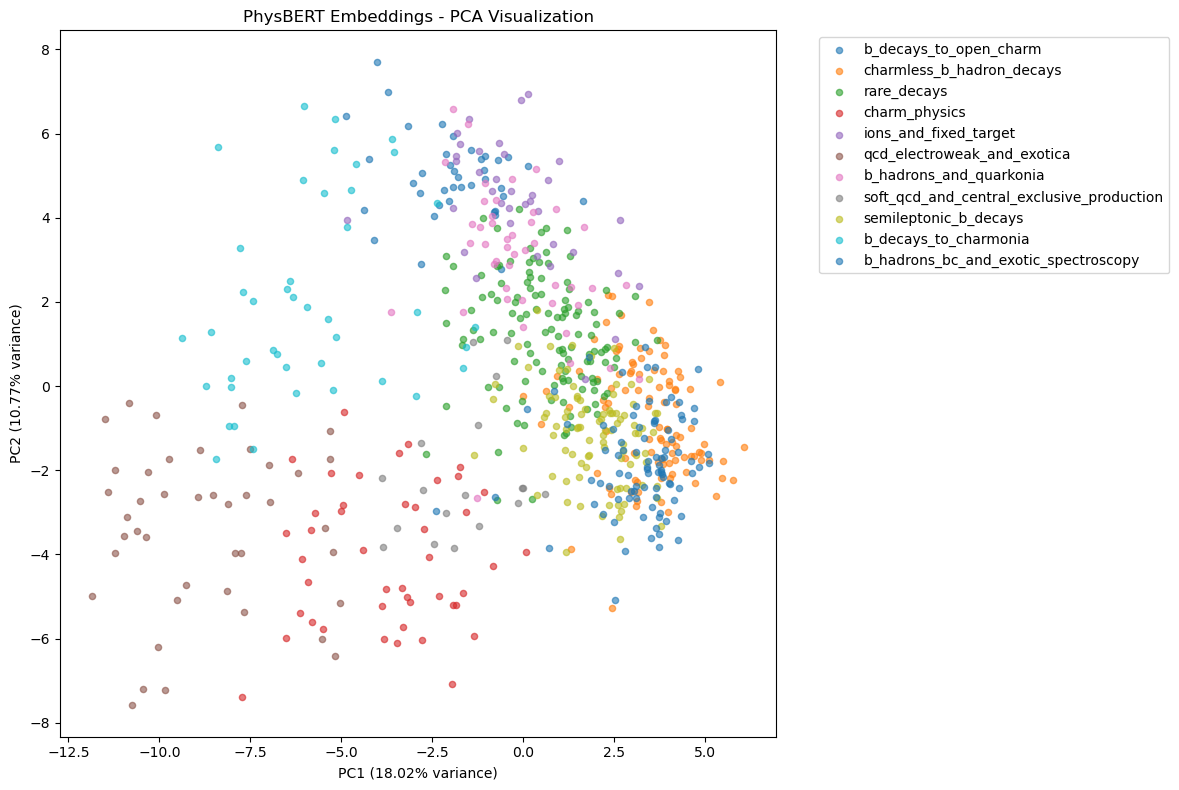

In [185]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Apply PCA
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(flattened_embeddings)

# Create scatter plot
plt.figure(figsize=(12, 8))

# Plot each cluster with a different color
for i, label in enumerate(wg_labels):
    mask = kmeans.labels_ == i
    plt.scatter(embeddings_2d[mask, 0], 
               embeddings_2d[mask, 1],
               label=label,
               alpha=0.6,  # Add some transparency
               s=20)  # Point size

# Add labels and title
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.2f}% variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.2f}% variance)')
plt.title('PhysBERT Embeddings - PCA Visualization')

# Add legend
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout to prevent legend cutoff
plt.tight_layout()

plt.show()